In [10]:
import pandas as pd
import numpy as np
from dateutil.parser import parse 
import matplotlib as mpl
import seaborn as sns
from matplotlib import pyplot as plt
import statsmodels.tsa.stattools as ts
import statsmodels.api as sm 
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf 
from datetime import datetime
import time
from scipy.interpolate import interp1d
import statsmodels.api as sm
import itertools
import seaborn as sns
# 设置中文和负号正常显示
plt.rcParams['font.sans-serif'] = 'Microsoft YaHei'
plt.rcParams['axes.unicode_minus'] = False

### 导入数据

In [11]:
df = pd.read_excel(r"F:\实验室\电网项目\服务器性能数据.xlsx", index_col=0)
df

,日期,DATA_DT,内存负载,主机CPU平均负载
0,2020-03-01 01:00:00,1582995600,81.8242,2.8333
1,2020-03-01 02:00:00,1582999200,81.8145,3.1818
2,2020-03-01 03:00:00,1583002800,81.8092,3.0833
3,2020-03-01 04:00:00,1583006400,81.8042,3.0833
4,2020-03-01 05:00:00,1583010000,81.8333,2.5000
...,...,...,...,...
2202,2020-05-31 19:00:00,1590922800,70.6183,2.0000
2203,2020-05-31 20:00:00,1590926400,70.5208,1.9167
2204,2020-05-31 21:00:00,1590930000,70.5608,1.7500
2205,2020-05-31 22:00:00,1590933600,70.5292,2.0000


In [12]:
df["内存负载"].isnull().any()

True

In [13]:
df.loc[174]

日期           2020-03-08 07:00:00
DATA_DT               1583622000
内存负载                     81.9075
主机CPU平均负载                 3.9167
Name: 174, dtype: object

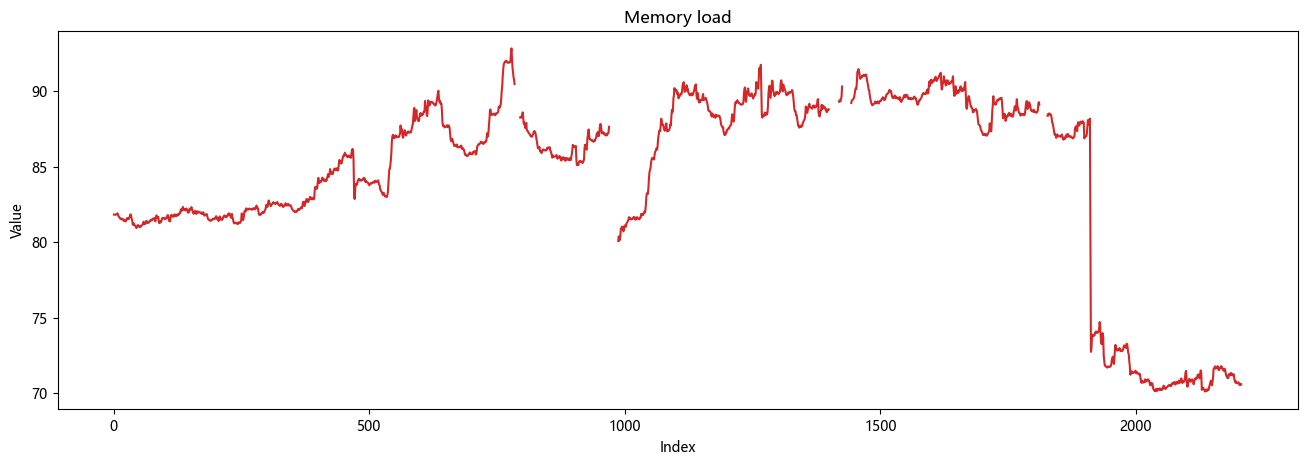

In [14]:
# Draw Plot-----绘图函数
def plot_df(df, x, y, title="", xlabel='Index', ylabel='Value', dpi=100):
    plt.figure(figsize=(16,5), dpi=dpi)
    plt.plot(x, y, color='tab:red')
    plt.gca().set(title=title, xlabel=xlabel, ylabel=ylabel)
    plt.show()
plot_df(df, x=df.index, y= df["内存负载"], title='Memory load')

### 缺失值填充

In [15]:
# k近邻法
def knn_mean(ts, n):
    out = np.copy(ts)
    for i, val in enumerate(ts):
        if np.isnan(val):
            n_by_2 = np.ceil(n / 2)
            lower = np.max([0, int(i - n_by_2)])
            upper = np.min([len(ts) + 1, int(i + n_by_2)])
            ts_near = np.concatenate([ts[lower:i], ts[i:upper]])
            out[i] = np.nanmean(ts_near)
    return out
# 使用k-近邻法填补缺失值
df["内存负载"] = knn_mean(df["内存负载"], 24)

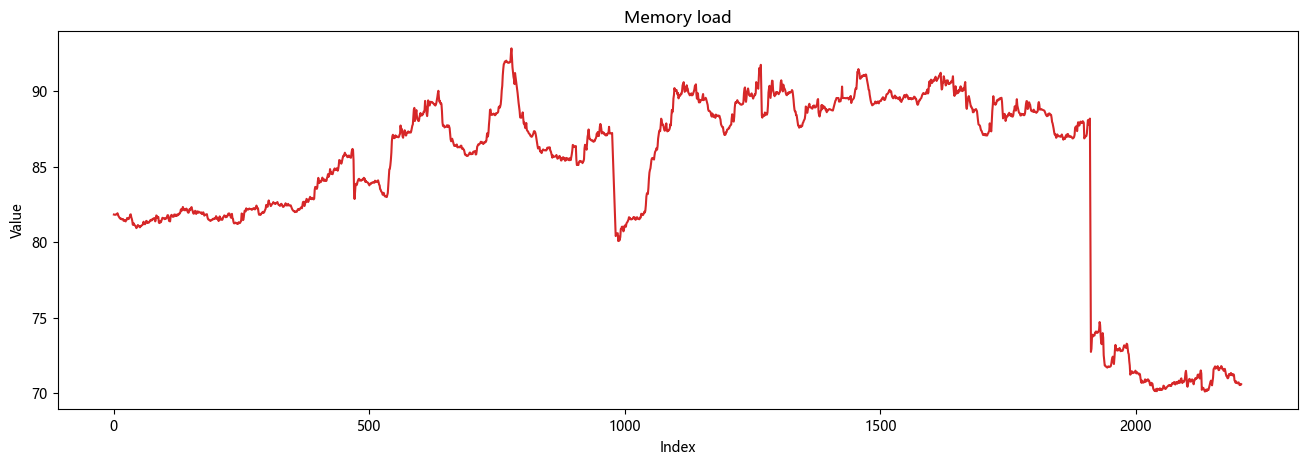

In [16]:
plot_df(df, x=df.index, y= df["内存负载"], title='Memory load')

In [17]:
df.loc[2201]

日期           2020-05-31 18:00:00
DATA_DT               1590919200
内存负载                     70.7008
主机CPU平均负载                 1.8333
Name: 2201, dtype: object

### 去除季节性因素

In [18]:
temp_Series =df["内存负载"]

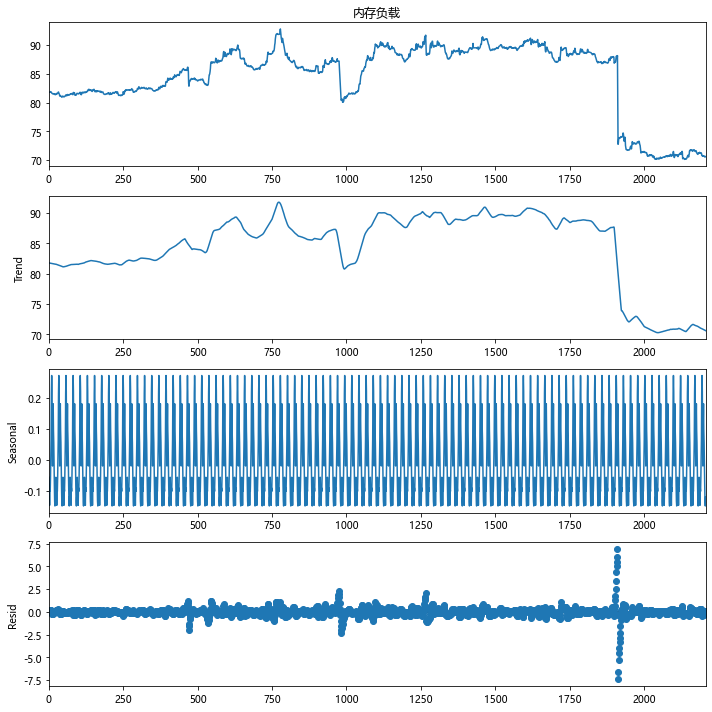

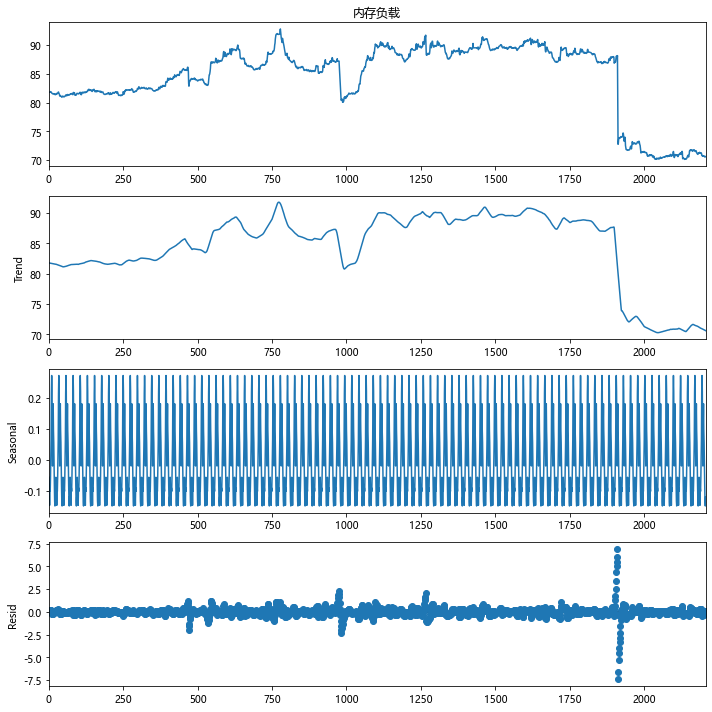

In [39]:
plt.rcParams.update({'figure.figsize': (10,10)})
result_add = sm.tsa.seasonal_decompose(temp_Series, model='additive',period = 24, extrapolate_trend='freq')
result_add.plot()

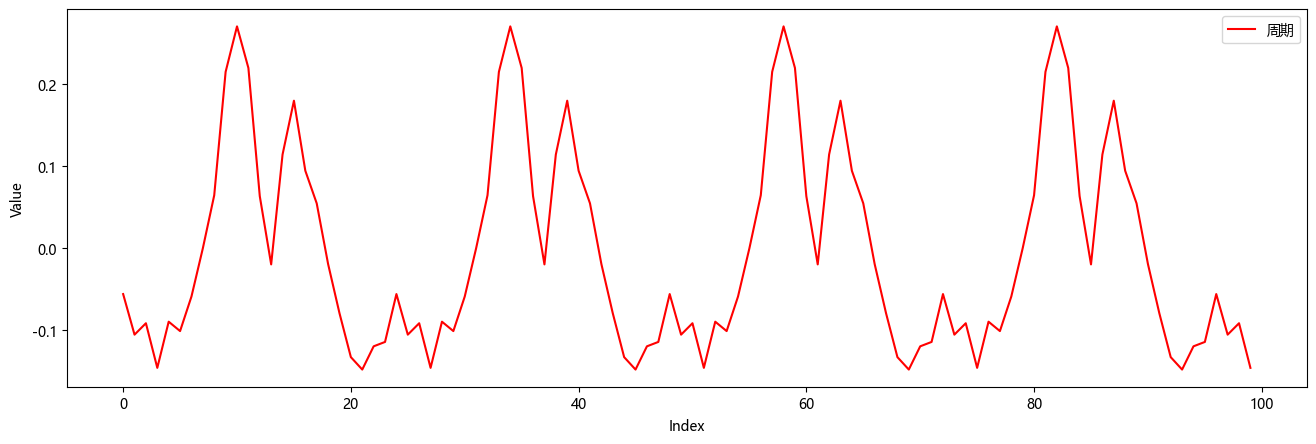

In [41]:
plt.figure(figsize=(16,5), dpi=100)
plt.plot((result_add.seasonal)[0:100],label = '周期', color = 'red')
# plt.plot((result_add.trend)[0:100],label = '趋势', color = 'black')
# plt.plot((result_add.resid)[0:100],label = '随机', color = 'black')
plt.xlabel('Index')
plt.ylabel('Value')
plt.legend(loc='best')

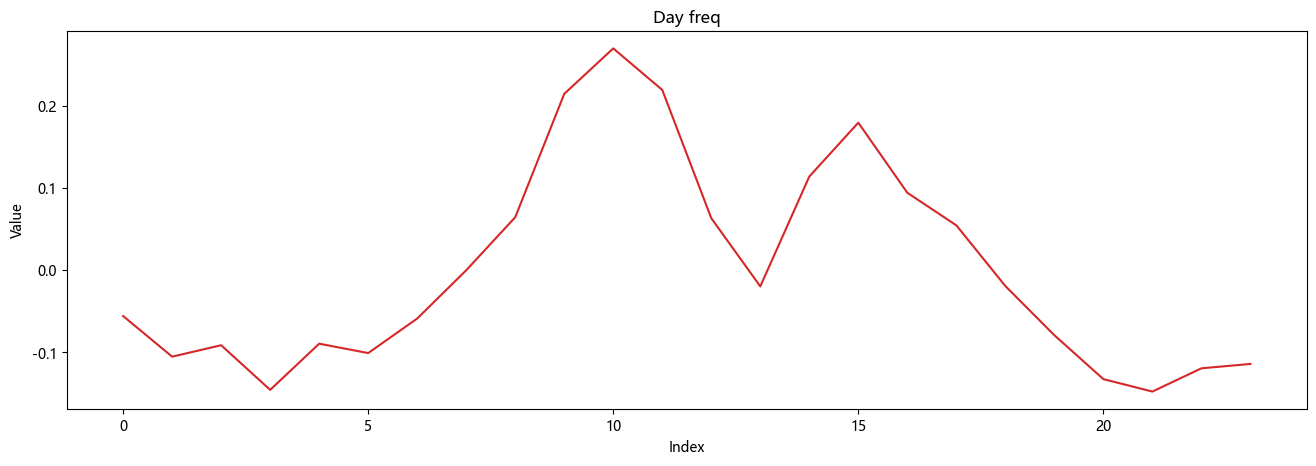

[-0.05566,
 -0.105116,
 -0.091199,
 -0.145571,
 -0.089326,
 -0.100757,
 -0.058671,
 0.000122,
 0.064746,
 0.215038,
 0.270441,
 0.219774,
 0.063583,
 -0.019519,
 0.114323,
 0.179914,
 0.094565,
 0.054839,
 -0.019065,
 -0.079007,
 -0.132503,
 -0.14764,
 -0.119328,
 -0.113983]

In [44]:
# 周期值24
a = result_add.seasonal
season = []
for i in range(24):
    season.append(float(format(a[i], '.6f')))
plot_df(season, x=range(24), y= season, title='Day freq')
season

In [45]:
arr = temp_Series - result_add.seasonal
arr

0       81.879860
1       81.919616
2       81.900399
3       81.949771
4       81.922626
          ...    
2202    70.637365
2203    70.599807
2204    70.693303
2205    70.676840
2206    70.699328
Length: 2207, dtype: float64

### 准备数据

In [46]:
train = arr[0:2046]
test = arr[2046:]
train

0       81.879860
1       81.919616
2       81.900399
3       81.949771
4       81.922626
          ...    
2041    70.219316
2042    70.371199
2043    70.375571
2044    70.323526
2045    70.317457
Length: 2046, dtype: float64

In [51]:
adftrain = ts.adfuller(train)
adftrain

(-0.791354363928442,
 0.8216484753884293,
 3,
 2042,
 {'1%': -3.433556434584693,
  '5%': -2.862956446160557,
  '10%': -2.5675240526993854},
 467.2153618176485)

### 9.预测

In [47]:
model = sm.tsa.ARIMA(train, order=(0, 1, 2))
result = model.fit()

In [48]:
te = result.predict(start=1,end=2039, dynamic=False, typ='levels')
len(te.values)

2039

In [16]:
num = 12
result = model.fit()
foreca = result.forecast(num)
test_Y = foreca[0]
test_Y

array([70.31280789, 70.30721427, 70.3015807 , 70.29594713, 70.29031357,
       70.28468   , 70.27904643, 70.27341286, 70.26777929, 70.26214573,
       70.25651216, 70.25087859])

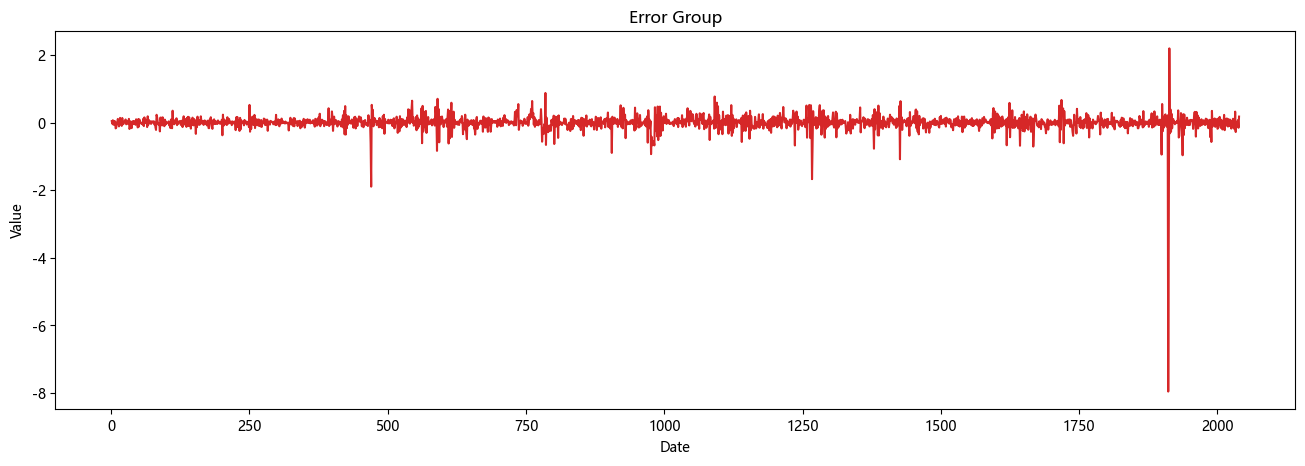

In [17]:
arr1 = train[1:2040] - te.values
error = pd.Series(arr1,index=te.index)
plot_df(error, x=error.index, y= error.values, title='Error Group')

In [18]:
from scipy.interpolate import UnivariateSpline
from numpy import linspace,exp
from numpy.random import randn
import scipy
from statsmodels.nonparametric.smoothers_lowess import lowess
error

1       0.045389
2      -0.033084
3       0.071377
4      -0.059297
5       0.049489
          ...   
2035    0.005526
2036   -0.005833
2037    0.074634
2038   -0.150794
2039    0.180173
Length: 2039, dtype: float64

In [19]:
error_temp = pd.DataFrame(error)
des = error_temp.describe()
U = des.iloc[6]
L = des.iloc[4]
IQR = U-L
top = U+1.5*IQR
bottom = L-1.5*IQR
des

,0
count,2039.000000
mean,0.000014
std,0.270406
min,-7.956998
25%,-0.069766
50%,0.007307
75%,0.088974
max,2.198722


In [20]:
for i in range(len(error)):
    if (error.iloc[i] > top).bool():
        error.iloc[i] = np.nan
    if (error.iloc[i] < bottom).bool():
        error.iloc[i] = np.nan

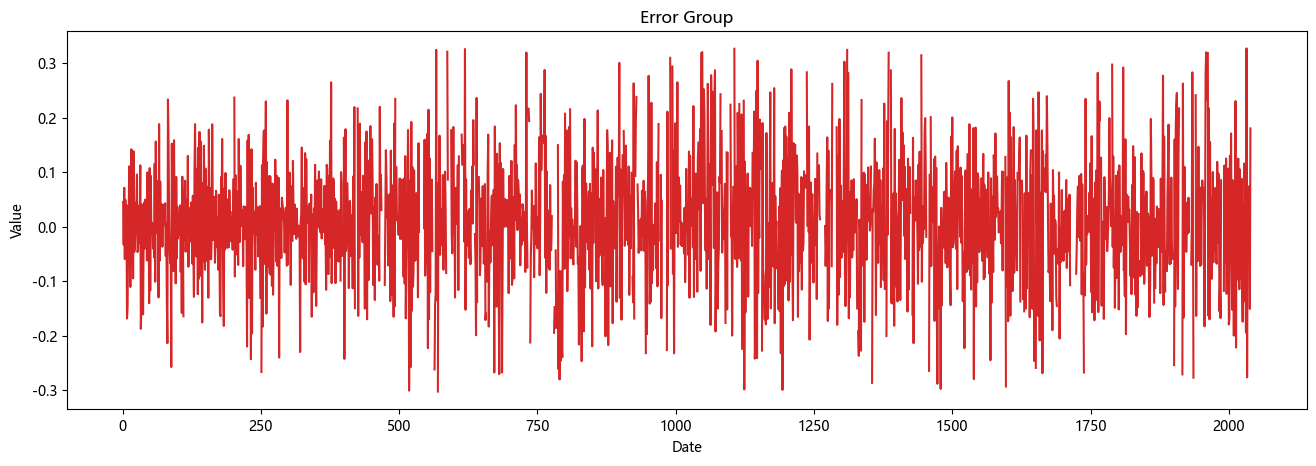

In [21]:
plot_df(error, x=error.index, y= error.values, title='Error Group')

In [22]:
error_temp2 = pd.DataFrame(error)
error_temp2.columns = ["value"]
print(f"缺失率为:{(100-(error_temp2.count()/(len(error))*100)).item()}%")

缺失率为:8.092202059833255%


In [23]:
error_temp2["value"] = knn_mean(error_temp2["value"], 9)

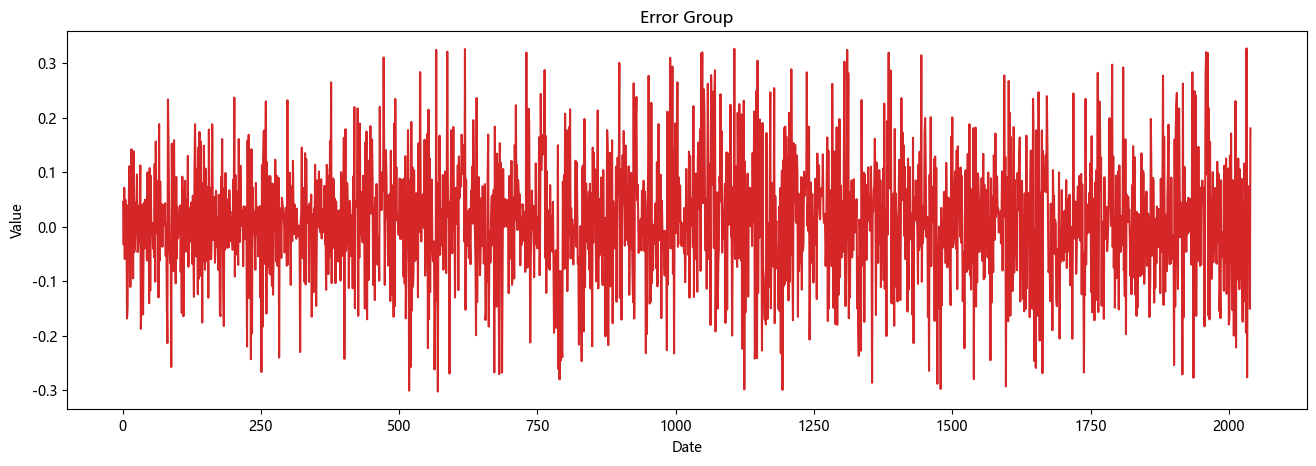

In [24]:
plot_df(error_temp2["value"], x=error_temp2["value"].index, y= error_temp2["value"].values, title='Error Group')

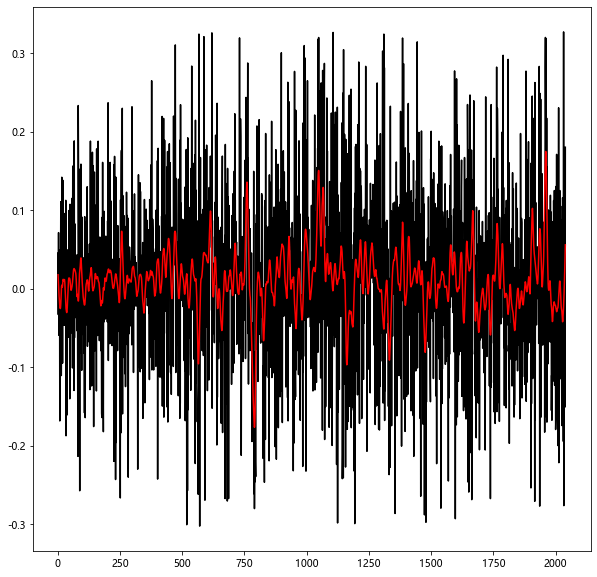

In [25]:
# Loess Smoothing (5% and 15%)
df_loess_5 = pd.DataFrame(lowess(error_temp2["value"], np.arange(len(error_temp2["value"])), frac=0.008)[:, 1], index=error.index, columns=['value'])
# df_loess_15 = pd.DataFrame(lowess(df_orig.value, np.arange(len(df_orig.value)), frac=0.15)[:, 1], index=df_orig.index, columns=['value'])
plt.plot(error,color = 'black')
plt.plot(df_loess_5,label = '拟合曲线',color = 'red')

In [26]:
# 索引185指18点
truth = df_loess_5["value"].loc[168:2040]

In [27]:
# 每天的7点到18点的内存负载数据
# label矩阵 从第8天算共78天的误差数据,索引168:2039
label = [] 
for i in range(78):
    arr = truth.loc[174+i*24:185+i*24].values
    label.append(arr)
# len(label) # 维度 78*12

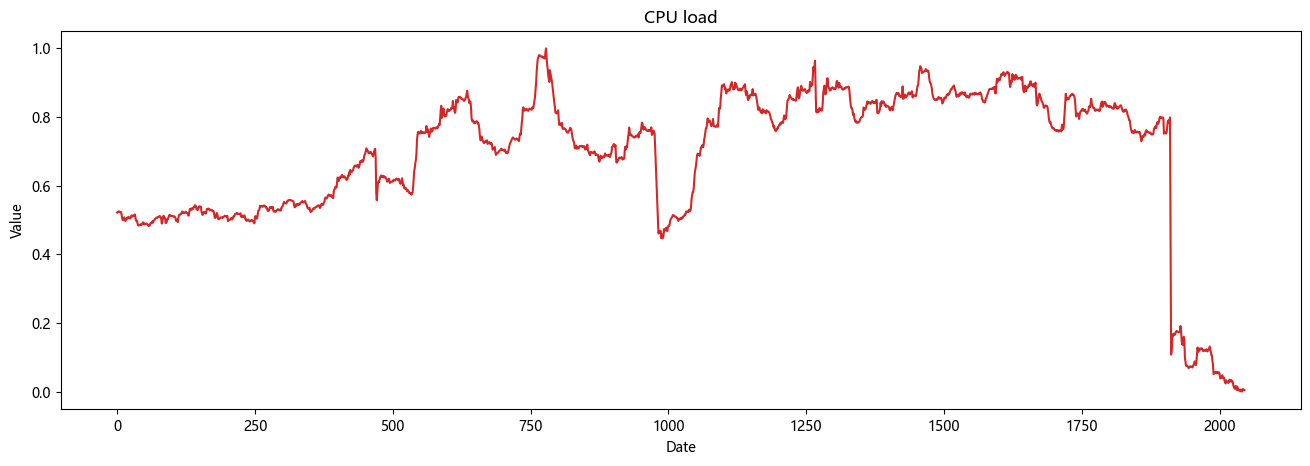

In [28]:
max_value = train.max(axis=0, skipna=True)
min_value = train.min(axis=0, skipna=True)
scalar = max_value - min_value
for i in range(len(train)):
    train[i]=(train[i]-min_value)/scalar
plot_df(df, x=df.index[0:2046], y= train, title='CPU load')

In [29]:
LSTM_input = []
for i in range(78):
    arr = train.loc[6+i*24:173+i*24]
    LSTM_input.append(arr.values)
ma = pd.DataFrame(LSTM_input)
ma

,0,1,2,3,4,5,6,7,8,9,...,158,159,160,161,162,163,164,165,166,167
0,0.522865,0.523139,0.516259,0.505282,0.500095,0.499959,0.505123,0.507535,0.502405,0.497044,...,0.532283,0.531246,0.533300,0.531418,0.528025,0.529791,0.529468,0.529140,0.529120,0.525268
1,0.512756,0.512067,0.516147,0.510227,0.499119,0.497015,0.497394,0.489858,0.484204,0.484961,...,0.507557,0.506780,0.507044,0.508223,0.506691,0.508524,0.510784,0.512322,0.511559,0.510388
2,0.489373,0.487453,0.485541,0.482346,0.485859,0.483848,0.488229,0.491510,0.490769,0.491902,...,0.509499,0.513569,0.517372,0.518037,0.519186,0.520840,0.518016,0.517692,0.518084,0.516729
3,0.510147,0.508858,0.502574,0.489431,0.494264,0.506748,0.512207,0.511116,0.506916,0.503784,...,0.499166,0.500739,0.500814,0.499608,0.495392,0.496786,0.497770,0.498408,0.500366,0.498569
4,0.509923,0.509270,0.510728,0.507743,0.505152,0.497538,0.497515,0.500711,0.493938,0.505547,...,0.539595,0.540980,0.540160,0.539107,0.538394,0.541838,0.539984,0.541858,0.539825,0.539812
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73,0.814350,0.809853,0.810989,0.816086,0.817970,0.830643,0.830284,0.828297,0.839166,0.853312,...,0.163453,0.168717,0.167150,0.165645,0.171537,0.174494,0.176596,0.175373,0.174310,0.173627
74,0.817407,0.819810,0.829896,0.838650,0.843779,0.845299,0.829617,0.834191,0.839201,0.844098,...,0.077117,0.075073,0.073430,0.072000,0.067712,0.072423,0.073178,0.073750,0.071345,0.072599
75,0.825350,0.824026,0.824043,0.837420,0.840758,0.835615,0.827822,0.831565,0.826286,0.824020,...,0.125485,0.122770,0.125531,0.125515,0.125890,0.122545,0.118042,0.121111,0.120348,0.119741
76,0.821810,0.819032,0.814421,0.805941,0.802866,0.796483,0.790978,0.790705,0.776848,0.766081,...,0.077376,0.050943,0.052361,0.054807,0.057043,0.056459,0.053116,0.057527,0.054786,0.055369


### 神经网络训练误差数据

In [30]:
import torch
from torch.autograd import Variable
import torch.nn as nn
from torch.nn import init
import torch.nn.functional as F
from torch.utils.data import DataLoader

In [31]:
train_X = torch.Tensor(np.array(LSTM_input).reshape(-1, 7, 24))
train_Y = torch.Tensor(np.array(label).reshape(-1, 1, 12))
train_X.shape

torch.Size([78, 7, 24])

In [32]:
test_X = torch.Tensor(np.array(train.loc[1878:2045]).reshape(-1, 7, 24))
test_X.shape

torch.Size([1, 7, 24])

In [33]:
class lstm(nn.Module):
    def __init__(self,input_size=16,hidden_size=100,output_size=1,num_layer=2):
        super(lstm,self).__init__()
        self.layer1 = nn.LSTM(input_size,hidden_size,num_layer,batch_first=True)
        self.layer2 = nn.Linear(hidden_size,output_size)
    
    def forward(self,x):
        x,_ = self.layer1(x)
        x = x[:,[6],:]
        b, s, h = x.size()
        x = x.view(-1,h)
        x = self.layer2(x)
        x = x.view(b, s, -1)
        return x

model = lstm(24, 128, 12, 1)
model

lstm(
  (layer1): LSTM(24, 128, batch_first=True)
  (layer2): Linear(in_features=128, out_features=12, bias=True)
)

In [34]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)
epoch_n = 5000

In [35]:
# 开始训练
ep=[]
losses = []
lr_list = []
for e in range(epoch_n):
    var_x = Variable(train_X)
    var_y = Variable(train_Y)
    # 前向传播
    out = model(var_x)
    loss = criterion(out, var_y)
    # 反向传播
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if (e + 1) % 5 == 0: # 每 2 次输出结果
        print('Epoch: {}, Loss: {:.8f}'.format(e + 1, loss.item()))
    ep.append(e+1)
    losses.append(loss.item())
#     break
    if (e+1)%500 == 0:
        for p in optimizer.param_groups:
            p['lr'] *= 0.1
    lr_list.append(optimizer.state_dict()['param_groups'][0]['lr'])

print('Finished Training') 

Epoch: 5, Loss: 0.00886923
Epoch: 10, Loss: 0.00284624
Epoch: 15, Loss: 0.00228026
Epoch: 20, Loss: 0.00211577
Epoch: 25, Loss: 0.00209848
Epoch: 30, Loss: 0.00192164
Epoch: 35, Loss: 0.00189911
Epoch: 40, Loss: 0.00187473
Epoch: 45, Loss: 0.00182631
Epoch: 50, Loss: 0.00181067
Epoch: 55, Loss: 0.00178962
Epoch: 60, Loss: 0.00176490
Epoch: 65, Loss: 0.00174503
Epoch: 70, Loss: 0.00172342
Epoch: 75, Loss: 0.00170039
Epoch: 80, Loss: 0.00167801
Epoch: 85, Loss: 0.00165404
Epoch: 90, Loss: 0.00162104
Epoch: 95, Loss: 0.00159669
Epoch: 100, Loss: 0.00157321
Epoch: 105, Loss: 0.00154627
Epoch: 110, Loss: 0.00152954
Epoch: 115, Loss: 0.00151324
Epoch: 120, Loss: 0.00151101
Epoch: 125, Loss: 0.00150373
Epoch: 130, Loss: 0.00148764
Epoch: 135, Loss: 0.00147978
Epoch: 140, Loss: 0.00147596
Epoch: 145, Loss: 0.00147001
Epoch: 150, Loss: 0.00146379
Epoch: 155, Loss: 0.00145960
Epoch: 160, Loss: 0.00145505
Epoch: 165, Loss: 0.00145044
Epoch: 170, Loss: 0.00144635
Epoch: 175, Loss: 0.00144179
Epoch

Epoch: 1415, Loss: 0.00054288
Epoch: 1420, Loss: 0.00054237
Epoch: 1425, Loss: 0.00054185
Epoch: 1430, Loss: 0.00054133
Epoch: 1435, Loss: 0.00054081
Epoch: 1440, Loss: 0.00054029
Epoch: 1445, Loss: 0.00053977
Epoch: 1450, Loss: 0.00053924
Epoch: 1455, Loss: 0.00053872
Epoch: 1460, Loss: 0.00053819
Epoch: 1465, Loss: 0.00053765
Epoch: 1470, Loss: 0.00053712
Epoch: 1475, Loss: 0.00053658
Epoch: 1480, Loss: 0.00053605
Epoch: 1485, Loss: 0.00053551
Epoch: 1490, Loss: 0.00053496
Epoch: 1495, Loss: 0.00053442
Epoch: 1500, Loss: 0.00053387
Epoch: 1505, Loss: 0.00053372
Epoch: 1510, Loss: 0.00053366
Epoch: 1515, Loss: 0.00053361
Epoch: 1520, Loss: 0.00053355
Epoch: 1525, Loss: 0.00053350
Epoch: 1530, Loss: 0.00053344
Epoch: 1535, Loss: 0.00053339
Epoch: 1540, Loss: 0.00053333
Epoch: 1545, Loss: 0.00053328
Epoch: 1550, Loss: 0.00053322
Epoch: 1555, Loss: 0.00053316
Epoch: 1560, Loss: 0.00053311
Epoch: 1565, Loss: 0.00053305
Epoch: 1570, Loss: 0.00053300
Epoch: 1575, Loss: 0.00053294
Epoch: 158

Epoch: 2790, Loss: 0.00052690
Epoch: 2795, Loss: 0.00052690
Epoch: 2800, Loss: 0.00052690
Epoch: 2805, Loss: 0.00052690
Epoch: 2810, Loss: 0.00052690
Epoch: 2815, Loss: 0.00052689
Epoch: 2820, Loss: 0.00052689
Epoch: 2825, Loss: 0.00052689
Epoch: 2830, Loss: 0.00052689
Epoch: 2835, Loss: 0.00052689
Epoch: 2840, Loss: 0.00052689
Epoch: 2845, Loss: 0.00052689
Epoch: 2850, Loss: 0.00052689
Epoch: 2855, Loss: 0.00052689
Epoch: 2860, Loss: 0.00052689
Epoch: 2865, Loss: 0.00052689
Epoch: 2870, Loss: 0.00052688
Epoch: 2875, Loss: 0.00052688
Epoch: 2880, Loss: 0.00052688
Epoch: 2885, Loss: 0.00052688
Epoch: 2890, Loss: 0.00052688
Epoch: 2895, Loss: 0.00052688
Epoch: 2900, Loss: 0.00052688
Epoch: 2905, Loss: 0.00052688
Epoch: 2910, Loss: 0.00052688
Epoch: 2915, Loss: 0.00052688
Epoch: 2920, Loss: 0.00052688
Epoch: 2925, Loss: 0.00052687
Epoch: 2930, Loss: 0.00052687
Epoch: 2935, Loss: 0.00052687
Epoch: 2940, Loss: 0.00052687
Epoch: 2945, Loss: 0.00052687
Epoch: 2950, Loss: 0.00052687
Epoch: 295

Epoch: 4160, Loss: 0.00052685
Epoch: 4165, Loss: 0.00052685
Epoch: 4170, Loss: 0.00052685
Epoch: 4175, Loss: 0.00052685
Epoch: 4180, Loss: 0.00052685
Epoch: 4185, Loss: 0.00052685
Epoch: 4190, Loss: 0.00052685
Epoch: 4195, Loss: 0.00052685
Epoch: 4200, Loss: 0.00052685
Epoch: 4205, Loss: 0.00052685
Epoch: 4210, Loss: 0.00052685
Epoch: 4215, Loss: 0.00052685
Epoch: 4220, Loss: 0.00052685
Epoch: 4225, Loss: 0.00052685
Epoch: 4230, Loss: 0.00052685
Epoch: 4235, Loss: 0.00052685
Epoch: 4240, Loss: 0.00052685
Epoch: 4245, Loss: 0.00052685
Epoch: 4250, Loss: 0.00052685
Epoch: 4255, Loss: 0.00052685
Epoch: 4260, Loss: 0.00052685
Epoch: 4265, Loss: 0.00052685
Epoch: 4270, Loss: 0.00052685
Epoch: 4275, Loss: 0.00052685
Epoch: 4280, Loss: 0.00052685
Epoch: 4285, Loss: 0.00052685
Epoch: 4290, Loss: 0.00052685
Epoch: 4295, Loss: 0.00052685
Epoch: 4300, Loss: 0.00052685
Epoch: 4305, Loss: 0.00052685
Epoch: 4310, Loss: 0.00052685
Epoch: 4315, Loss: 0.00052685
Epoch: 4320, Loss: 0.00052685
Epoch: 432

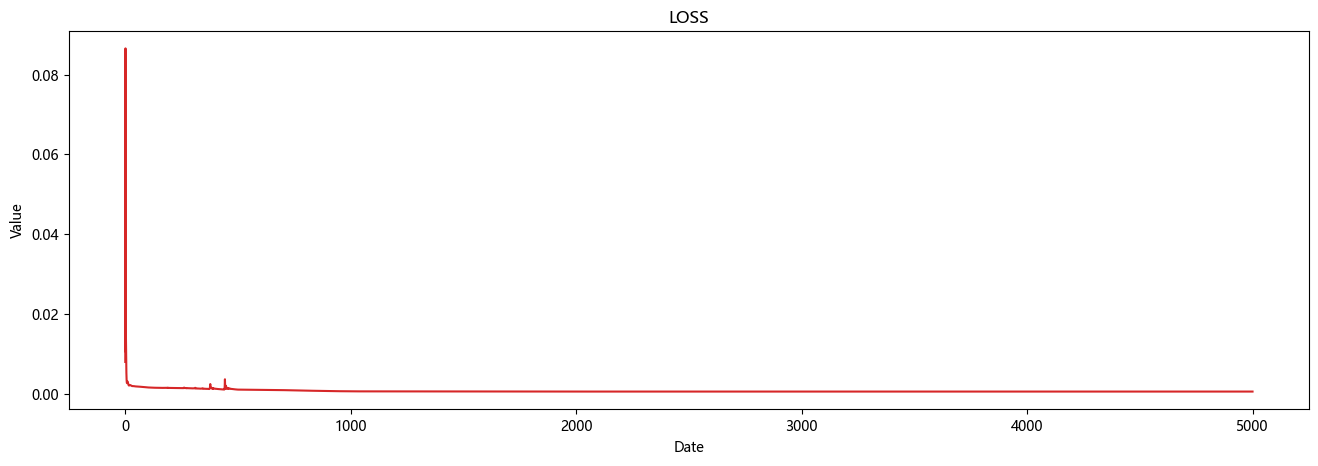

In [36]:
# plot_df(df, x=range(epoch_n), y= lr_list, title='LOSS')
plot_df(df, x=ep, y= losses, title='LOSS')

### 检验神经网络模型效果

In [37]:
torch.save(model, 'error_net.pkl')
model2 = torch.load('error_net.pkl')

D:\Softwore\python38\lib\site-packages\torch\serialization.py:359: UserWarning: Couldn't retrieve source code for container of type lstm. It won't be checked for correctness upon loading.
  warnings.warn("Couldn't retrieve source code for container of "


In [38]:
foreca_val = test_Y+result_add.seasonal[6:num+6]
# 加上周期值
top = []
bottom = []
for data in foreca[2]:
    top.append(data[1])
    bottom.append(data[0])
top = top + result_add.seasonal[6:num+6]
bottom = bottom + result_add.seasonal[6:num+6]

In [39]:
MSE = 0
for i in range(num):
    MSE += (foreca_val[6+i] - df["内存负载"].loc[2046+i])**2
MSE

0.3149229456785877

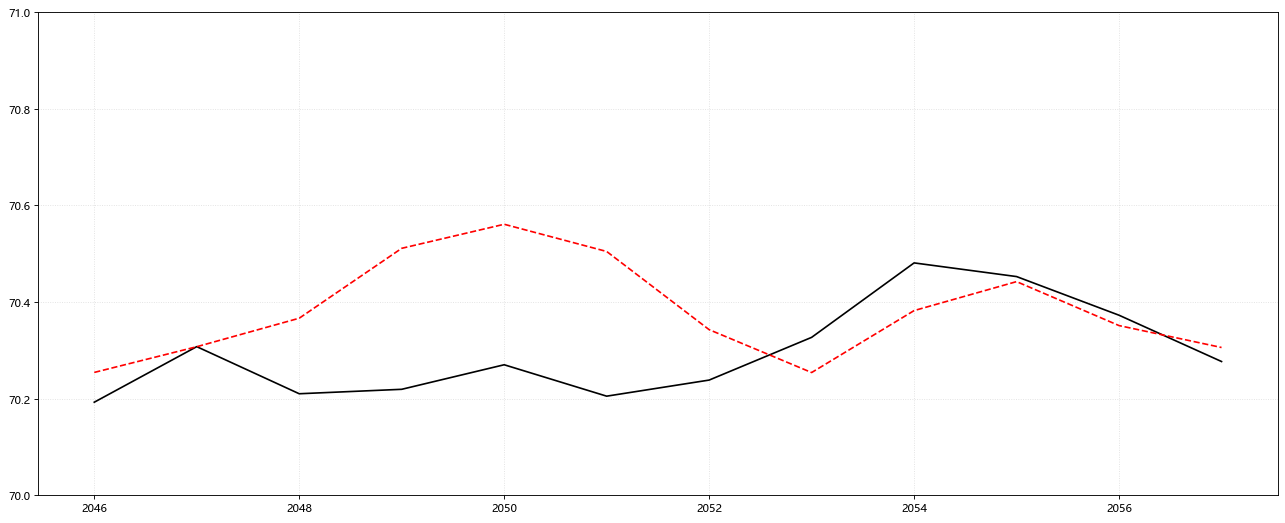

In [40]:
plt.figure(figsize=(20,8),dpi=80)
test_temp = df["内存负载"][len(train):len(train)+num]
# color可以百度颜色代码
plt.plot(test_temp.index,test_temp,label="truth",color="black")
plt.plot(test_temp.index,foreca_val,label="predict",color="red",linestyle="--")
# plt.fill_between(test_temp.index,top,bottom,color='blue',alpha=0.05)
#绘制网格
plt.grid(alpha=0.4,linestyle=':')
plt.ylim(70,71)
#展示
plt.show()

In [41]:
outputs = model2(torch.Tensor(np.array(test_X).reshape(-1, 7, 24)))
error_list = outputs.detach().numpy().tolist()
error_list[0][0]

[-0.0419950857758522,
 -0.05010689049959183,
 -0.04779166728258133,
 -0.04266921430826187,
 -0.041260916739702225,
 -0.05699361860752106,
 -0.0432058647274971,
 -0.07316157221794128,
 -0.05440884828567505,
 -0.03837710618972778,
 -0.03375338762998581,
 -0.04658875614404678]

In [42]:
prdict = foreca_val.values + error_list[0][0]
prdict

array([70.21214222, 70.25722916, 70.31853456, 70.46831568, 70.51949352,
       70.4474603 , 70.29942397, 70.18073275, 70.32769298, 70.40368273,
       70.31732358, 70.2591285 ])

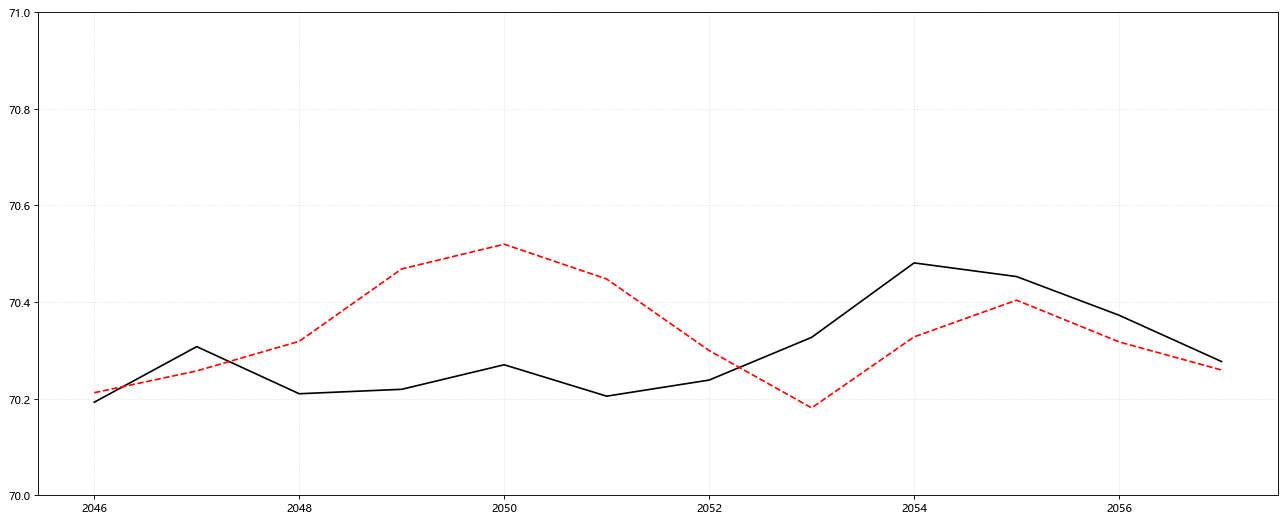

In [43]:
plt.figure(figsize=(20,8),dpi=80)
test_temp = df["内存负载"][len(train):len(train)+num]
plt.plot(test_temp.index,test_temp,label="truth",color="black")
plt.plot(test_temp.index,prdict,label="predict",color="red",linestyle="--")
plt.grid(alpha=0.4,linestyle=':')

plt.ylim(70,71)
#展示
plt.show()

In [44]:
MSE = 0
for i in range(num):
    MSE += (prdict[i] - df["内存负载"].loc[2046+i])**2
MSE

0.2520060206330969

### 差分

In [49]:
# # 差分法生成序列
dif = []
dif = train.diff(1)

### ADF检验

In [52]:
timeSeries = dif[1:]
adftest = ts.adfuller(timeSeries)
adftest

(-22.846640968410785,
 0.0,
 2,
 2042,
 {'1%': -3.433556434584693,
  '5%': -2.862956446160557,
  '10%': -2.5675240526993854},
 466.59611928977347)

### ACF和PACF观察

<ipython-input-54-76021bd838cb>:1: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  plot_acf(timeSeries).show()


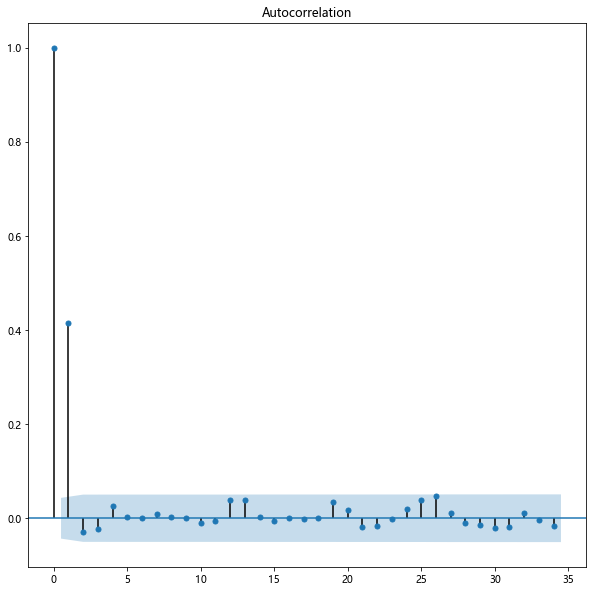

In [54]:
plot_acf(timeSeries).show()

<ipython-input-53-6211f80bbc7a>:1: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  plot_pacf(timeSeries).show()


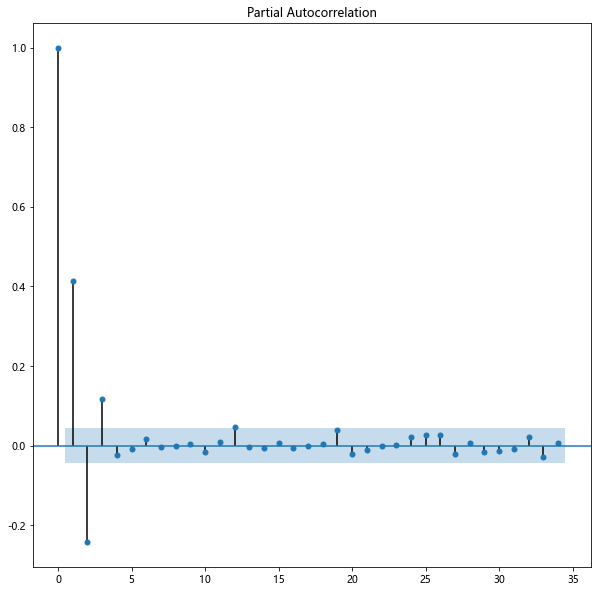

In [53]:
plot_pacf(timeSeries).show()

### BIC和AIC定阶

In [56]:
p_min = 0
q_min = 0
p_max = 5
q_max = 6
d_min = 0
d_max = 1

In [57]:
results_bic = pd.DataFrame(index=['AR{}'.format(i) for i in range(p_min,p_max+1)],
                           columns=['MA{}'.format(i) for i in range(q_min,q_max+1)])
results_bic

,MA0,MA1,MA2,MA3,MA4,MA5,MA6
AR0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AR1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AR2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AR3,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AR4,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AR5,NaN,NaN,NaN,NaN,NaN,NaN,NaN


D:\Softwore\python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
D:\Softwore\python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
D:\Softwore\python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'


循环2次
循环3次
循环4次


D:\Softwore\python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
D:\Softwore\python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'


循环5次
循环6次


D:\Softwore\python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'


循环7次
循环8次


D:\Softwore\python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
D:\Softwore\python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
D:\Softwore\python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
D:\Softwore\python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'


循环9次


D:\Softwore\python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
D:\Softwore\python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'


循环10次


D:\Softwore\python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
D:\Softwore\python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'


循环11次


D:\Softwore\python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
D:\Softwore\python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'


循环12次


D:\Softwore\python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
D:\Softwore\python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'


循环13次


D:\Softwore\python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
D:\Softwore\python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'


循环14次
循环15次


D:\Softwore\python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
D:\Softwore\python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'


循环16次


D:\Softwore\python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'


循环17次


D:\Softwore\python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'


循环18次


D:\Softwore\python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'


循环19次


D:\Softwore\python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'


循环20次


D:\Softwore\python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'


循环21次
循环22次


D:\Softwore\python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
D:\Softwore\python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
D:\Softwore\python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
D:\Softwore\python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'


循环23次


D:\Softwore\python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
D:\Softwore\python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'


循环24次


D:\Softwore\python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
D:\Softwore\python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'


循环25次


D:\Softwore\python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
D:\Softwore\python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'


循环26次


D:\Softwore\python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
D:\Softwore\python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
D:\Softwore\python38\lib\site-packages\statsmodels\base\model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warn('Inverting hessian failed, no bse or cov_params '
D:\Softwore\python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
D:\Softwore\python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:213: ValueWarning: 

循环27次
循环28次
循环29次


D:\Softwore\python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
D:\Softwore\python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'


循环30次


D:\Softwore\python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'


循环31次


D:\Softwore\python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'


循环32次


D:\Softwore\python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'


循环33次


D:\Softwore\python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'


循环34次


D:\Softwore\python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'


循环35次
循环36次


D:\Softwore\python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
D:\Softwore\python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
D:\Softwore\python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
D:\Softwore\python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'


循环37次


D:\Softwore\python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
D:\Softwore\python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'


循环38次


D:\Softwore\python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
D:\Softwore\python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'


循环39次


D:\Softwore\python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
D:\Softwore\python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
D:\Softwore\python38\lib\site-packages\statsmodels\tsa\tsatools.py:689: RuntimeWarning: overflow encountered in exp
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
D:\Softwore\python38\lib\site-packages\statsmodels\tsa\tsatools.py:689: RuntimeWarning: invalid value encountered in true_divide
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
D:\Softwore\python38\lib\site-packages\statsmodels\tsa\tsatools.py:690: RuntimeWarning: overflow encountered in exp
  tmp = ((1-np.exp(-params))/(1+np.exp(-params)

循环40次
循环41次


D:\Softwore\python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
D:\Softwore\python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
D:\Softwore\python38\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
D:\Softwore\python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
D:\Softwore\python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:213: V

循环42次
循环43次
循环44次


D:\Softwore\python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'


循环45次


D:\Softwore\python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'


循环46次


D:\Softwore\python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'


循环47次


D:\Softwore\python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'


循环48次


D:\Softwore\python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
D:\Softwore\python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
D:\Softwore\python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'


循环49次


D:\Softwore\python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
D:\Softwore\python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'


循环50次


D:\Softwore\python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
D:\Softwore\python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'


循环51次


D:\Softwore\python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
D:\Softwore\python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
D:\Softwore\python38\lib\site-packages\statsmodels\base\model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warn('Inverting hessian failed, no bse or cov_params '
D:\Softwore\python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
D:\Softwore\python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:213: ValueWarning: 

循环52次
循环53次


D:\Softwore\python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
D:\Softwore\python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
D:\Softwore\python38\lib\site-packages\statsmodels\base\model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warn('Inverting hessian failed, no bse or cov_params '
D:\Softwore\python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
D:\Softwore\python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:213: ValueWarning: 

循环54次


D:\Softwore\python38\lib\site-packages\statsmodels\base\model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warn('Inverting hessian failed, no bse or cov_params '
D:\Softwore\python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
D:\Softwore\python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'


循环55次
循环56次
循环57次


D:\Softwore\python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'


循环58次


D:\Softwore\python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'


循环59次


D:\Softwore\python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'


循环60次


D:\Softwore\python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
D:\Softwore\python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'


循环61次


D:\Softwore\python38\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
D:\Softwore\python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
D:\Softwore\python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'


循环62次
循环63次


D:\Softwore\python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
D:\Softwore\python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'


循环64次


D:\Softwore\python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
D:\Softwore\python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'


循环65次


D:\Softwore\python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
D:\Softwore\python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
D:\Softwore\python38\lib\site-packages\statsmodels\base\model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warn('Inverting hessian failed, no bse or cov_params '
D:\Softwore\python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
D:\Softwore\python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:213: ValueWarning: 

循环66次
循环67次


D:\Softwore\python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
D:\Softwore\python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
D:\Softwore\python38\lib\site-packages\statsmodels\base\model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warn('Inverting hessian failed, no bse or cov_params '
D:\Softwore\python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
D:\Softwore\python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:213: ValueWarning: 

循环68次


D:\Softwore\python38\lib\site-packages\statsmodels\base\model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warn('Inverting hessian failed, no bse or cov_params '
D:\Softwore\python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'


循环69次
循环70次


D:\Softwore\python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'


循环71次


D:\Softwore\python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'


循环72次


D:\Softwore\python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'


循环73次


D:\Softwore\python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'


循环74次


D:\Softwore\python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'


循环75次


D:\Softwore\python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'


循环76次


D:\Softwore\python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
D:\Softwore\python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'


循环77次


D:\Softwore\python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
D:\Softwore\python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'


循环78次


D:\Softwore\python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
D:\Softwore\python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
D:\Softwore\python38\lib\site-packages\statsmodels\base\model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warn('Inverting hessian failed, no bse or cov_params '
D:\Softwore\python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
D:\Softwore\python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:213: ValueWarning: 

循环79次
循环80次


D:\Softwore\python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
D:\Softwore\python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
D:\Softwore\python38\lib\site-packages\statsmodels\base\model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warn('Inverting hessian failed, no bse or cov_params '
D:\Softwore\python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
D:\Softwore\python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:213: ValueWarning: 

循环81次


D:\Softwore\python38\lib\site-packages\statsmodels\base\model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warn('Inverting hessian failed, no bse or cov_params '
D:\Softwore\python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
D:\Softwore\python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'


循环82次


D:\Softwore\python38\lib\site-packages\statsmodels\base\model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warn('Inverting hessian failed, no bse or cov_params '


循环83次


Text(0.5, 1.0, 'BIC')

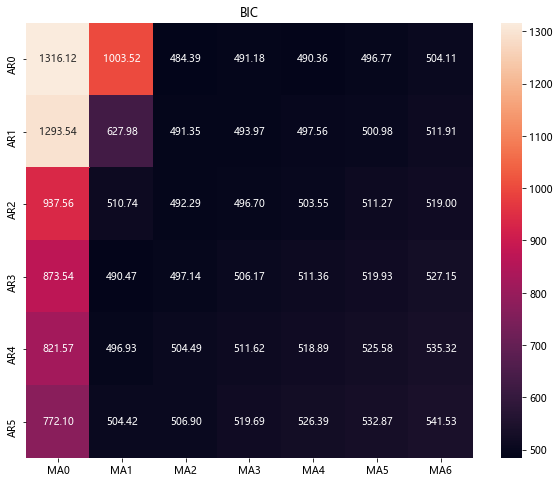

In [58]:
num = 1
for p,d,q in itertools.product(range(p_min,p_max+1),
                               range(d_min,d_max+1),
                               range(q_min,q_max+1)):
    if p==0 and d==0 and q==0:
        results_bic.loc['AR{}'.format(p), 'MA{}'.format(q)] = np.nan
        continue
 
    try:
        model = sm.tsa.ARIMA(timeSeries, order=(p, d, q),
#                                enforce_stationarity=False,
#                                enforce_invertibility=False,
                              )
        results = model.fit()
        num += 1
        print(f"循环{num}次")
        results_bic.loc['AR{}'.format(p), 'MA{}'.format(q)] = results.bic
    except:
        continue
results_bic = results_bic[results_bic.columns].astype(float)
fig, ax = plt.subplots(figsize=(10, 8))
ax = sns.heatmap(results_bic,
                 mask=results_bic.isnull(),
                 ax=ax,
                 annot=True,
                 fmt='.2f',
                 )
ax.set_title('BIC')

### 验证模型

D:\Softwore\python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
D:\Softwore\python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'


D-W检验值为1.9801766559857614


<Figure size 864x576 with 0 Axes>

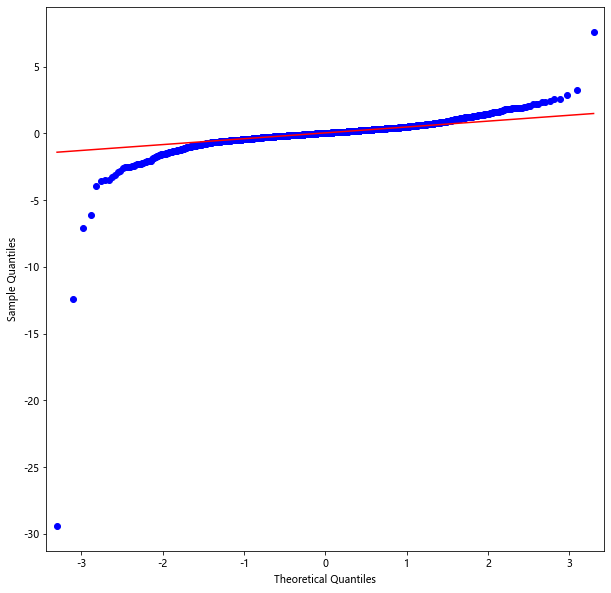

In [59]:
from statsmodels.graphics.api import qqplot
from statsmodels.stats.stattools import durbin_watson #DW检验
#残差
model = sm.tsa.ARIMA(timeSeries, order=(0, 1, 2))
results = model.fit()
resid = results.resid 
#利用QQ图检验残差是否满足正态分布
plt.figure(figsize=(12,8))
qqplot(resid,line='q',fit=True)
#利用D-W检验,检验残差的自相关性
print('D-W检验值为{}'.format(durbin_watson(resid.values)))
# 当D-W检验值接近于2时，不存在自相关性，说明模型较好。
# https://wenku.baidu.com/view/57224dcfcf84b9d528ea7aba.html